# Automatic label simple demo

In [1]:
import numpy as np
import supervision as sv
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torchvision

import intel_extension_for_pytorch as ipex

from segment_anything import sam_model_registry, SamPredictor

from Tag2Text.ram.models import ram
from Tag2Text import inference_ram

/home/wayne/ov/.env/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: ''If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
2023-09-22 13:24:34,205 - root - WARNING - Pytorch pre-release version 2.0.1a0+cxx11.abi - assuming intent to test it


In [2]:
from groundingdino.util.slconfig import SLConfig
from groundingdino.models import build_model
import groundingdino.datasets.transforms as T
from collections import OrderedDict

def gdino_load_image(image_path):
    # load image
    image_pil = Image.open(image_path).convert("RGB")  # load image
    transform = T.Compose([
        T.RandomResize([800], max_size=1333),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    image, _ = transform(image_pil, None)  # 3, h, w
    return image_pil, image

def clean_state_dict(state_dict):
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        if k[:7] == "module.":
            k = k[7:]  # remove `module.`
        new_state_dict[k] = v
    return new_state_dict

def load_model(model_config_path, model_checkpoint_path, bert_path):
    args = SLConfig.fromfile(model_config_path)
    args.device = "cpu"
    args.text_encoder_type = bert_path
    model = build_model(args)
    checkpoint = torch.load(model_checkpoint_path, map_location="cpu")
    load_res = model.load_state_dict(clean_state_dict(checkpoint["model"]), strict=False)
    #print(load_res)
    _ = model.eval()
    return model

In [3]:
import torchvision.transforms as T
def load_image(image_path, size=[384, 384]):
    # load image
    image_pil = Image.open(image_path).convert("RGB")  # load image
    transform = T.Compose([
        T.Resize(size),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    image = transform(image_pil)
    return image_pil, image[None]

In [4]:
def get_phrases_from_posmap(posmap, tokenized, tokenizer, left_idx = 0, right_idx = 255):
    if posmap.dim() == 1:
        posmap[0: left_idx + 1] = False
        posmap[right_idx:] = False
        non_zero_idx = posmap.nonzero(as_tuple=True)[0].tolist()
        token_ids = [tokenized["input_ids"][i] for i in non_zero_idx]
        return tokenizer.decode(token_ids).replace('.', '')
    else:
        raise NotImplementedError("posmap must be 1-dim")

In [29]:
from typing import List

def find_index(string, lst):
    # if meet string like "lake river" will only keep "lake"
    # this is an hack implementation for visualization which will be updated in the future
    string = string.lower().split()[0]
    for i, s in enumerate(lst):
        if string in s.lower():
            return i
    return 0
def phrases2classes(phrases: List[str], classes: List[str]) -> np.ndarray:
    class_ids = []
    for phrase in phrases:
        try:
            class_ids.append(find_index(phrase, classes))
        except ValueError:
            class_ids.append(None)
    return np.array(class_ids)

In [6]:
def get_grounding_output(model, image, classes, box_threshold=.3, text_threshold=.25):
    for c in classes:
        c = c.strip().lower()
        #if not caption.endswith("."):
        #    caption = caption + "."
    captions = [". ".join(classes)+"."]
    device = torch.device("xpu")
    #model = model.to(device)
    #model = ipex.optimize(model)
    #image = image.to(device)
    with torch.no_grad():
        outputs = model(image, captions=captions)
    logits = outputs["pred_logits"].sigmoid()[0]
    boxes = outputs["pred_boxes"][0]
    # filter output
    logits_filt = logits.cpu().clone()
    boxes_filt = boxes.cpu().clone()
    filt_mask = logits_filt.max(dim=1)[0] > box_threshold
    logits_filt = logits_filt[filt_mask]
    boxes_filt = boxes_filt[filt_mask]

    # get phrase
    for i, caption in enumerate(captions):
        tokenized = model.tokenizer(caption)
        # build pred
        pred_phrases = [get_phrases_from_posmap(logit > text_threshold, tokenized, model.tokenizer) for logit in logits_filt]
    return boxes_filt, logits_filt.max(dim=1)[0], pred_phrases

In [43]:
from torchvision.ops import box_convert

def post_process_result(
        source_h: int,
        source_w: int,
        boxes: torch.Tensor,
        logits: torch.Tensor,
        phrases
) -> sv.Detections:
    boxes = boxes * torch.Tensor([source_w, source_h, source_w, source_h])
    xyxy = box_convert(boxes=boxes, in_fmt="cxcywh", out_fmt="xyxy").numpy()
    confidence = logits.numpy()
    class_ids = phrases2classes(phrases, classes)
    return sv.Detections(xyxy=xyxy, confidence=confidence, class_id = class_ids)

In [8]:
# Prompting SAM with detected boxes
def segment(sam_predictor: SamPredictor, image: np.ndarray, xyxy: np.ndarray) -> np.ndarray:
    sam_predictor.set_image(image)
    result_masks = []
    for box in xyxy:
        masks, scores, logits = sam_predictor.predict(
            box=box,
            multimask_output=True
        )
        index = np.argmax(scores)
        result_masks.append(masks[index])
    return np.array(result_masks)

In [9]:
BERT_PATH = "checkpoints/bert-base-uncased"

In [44]:
image_path = 'assets/demo9.jpg'

In [45]:
image_pil, image = load_image(image_path)

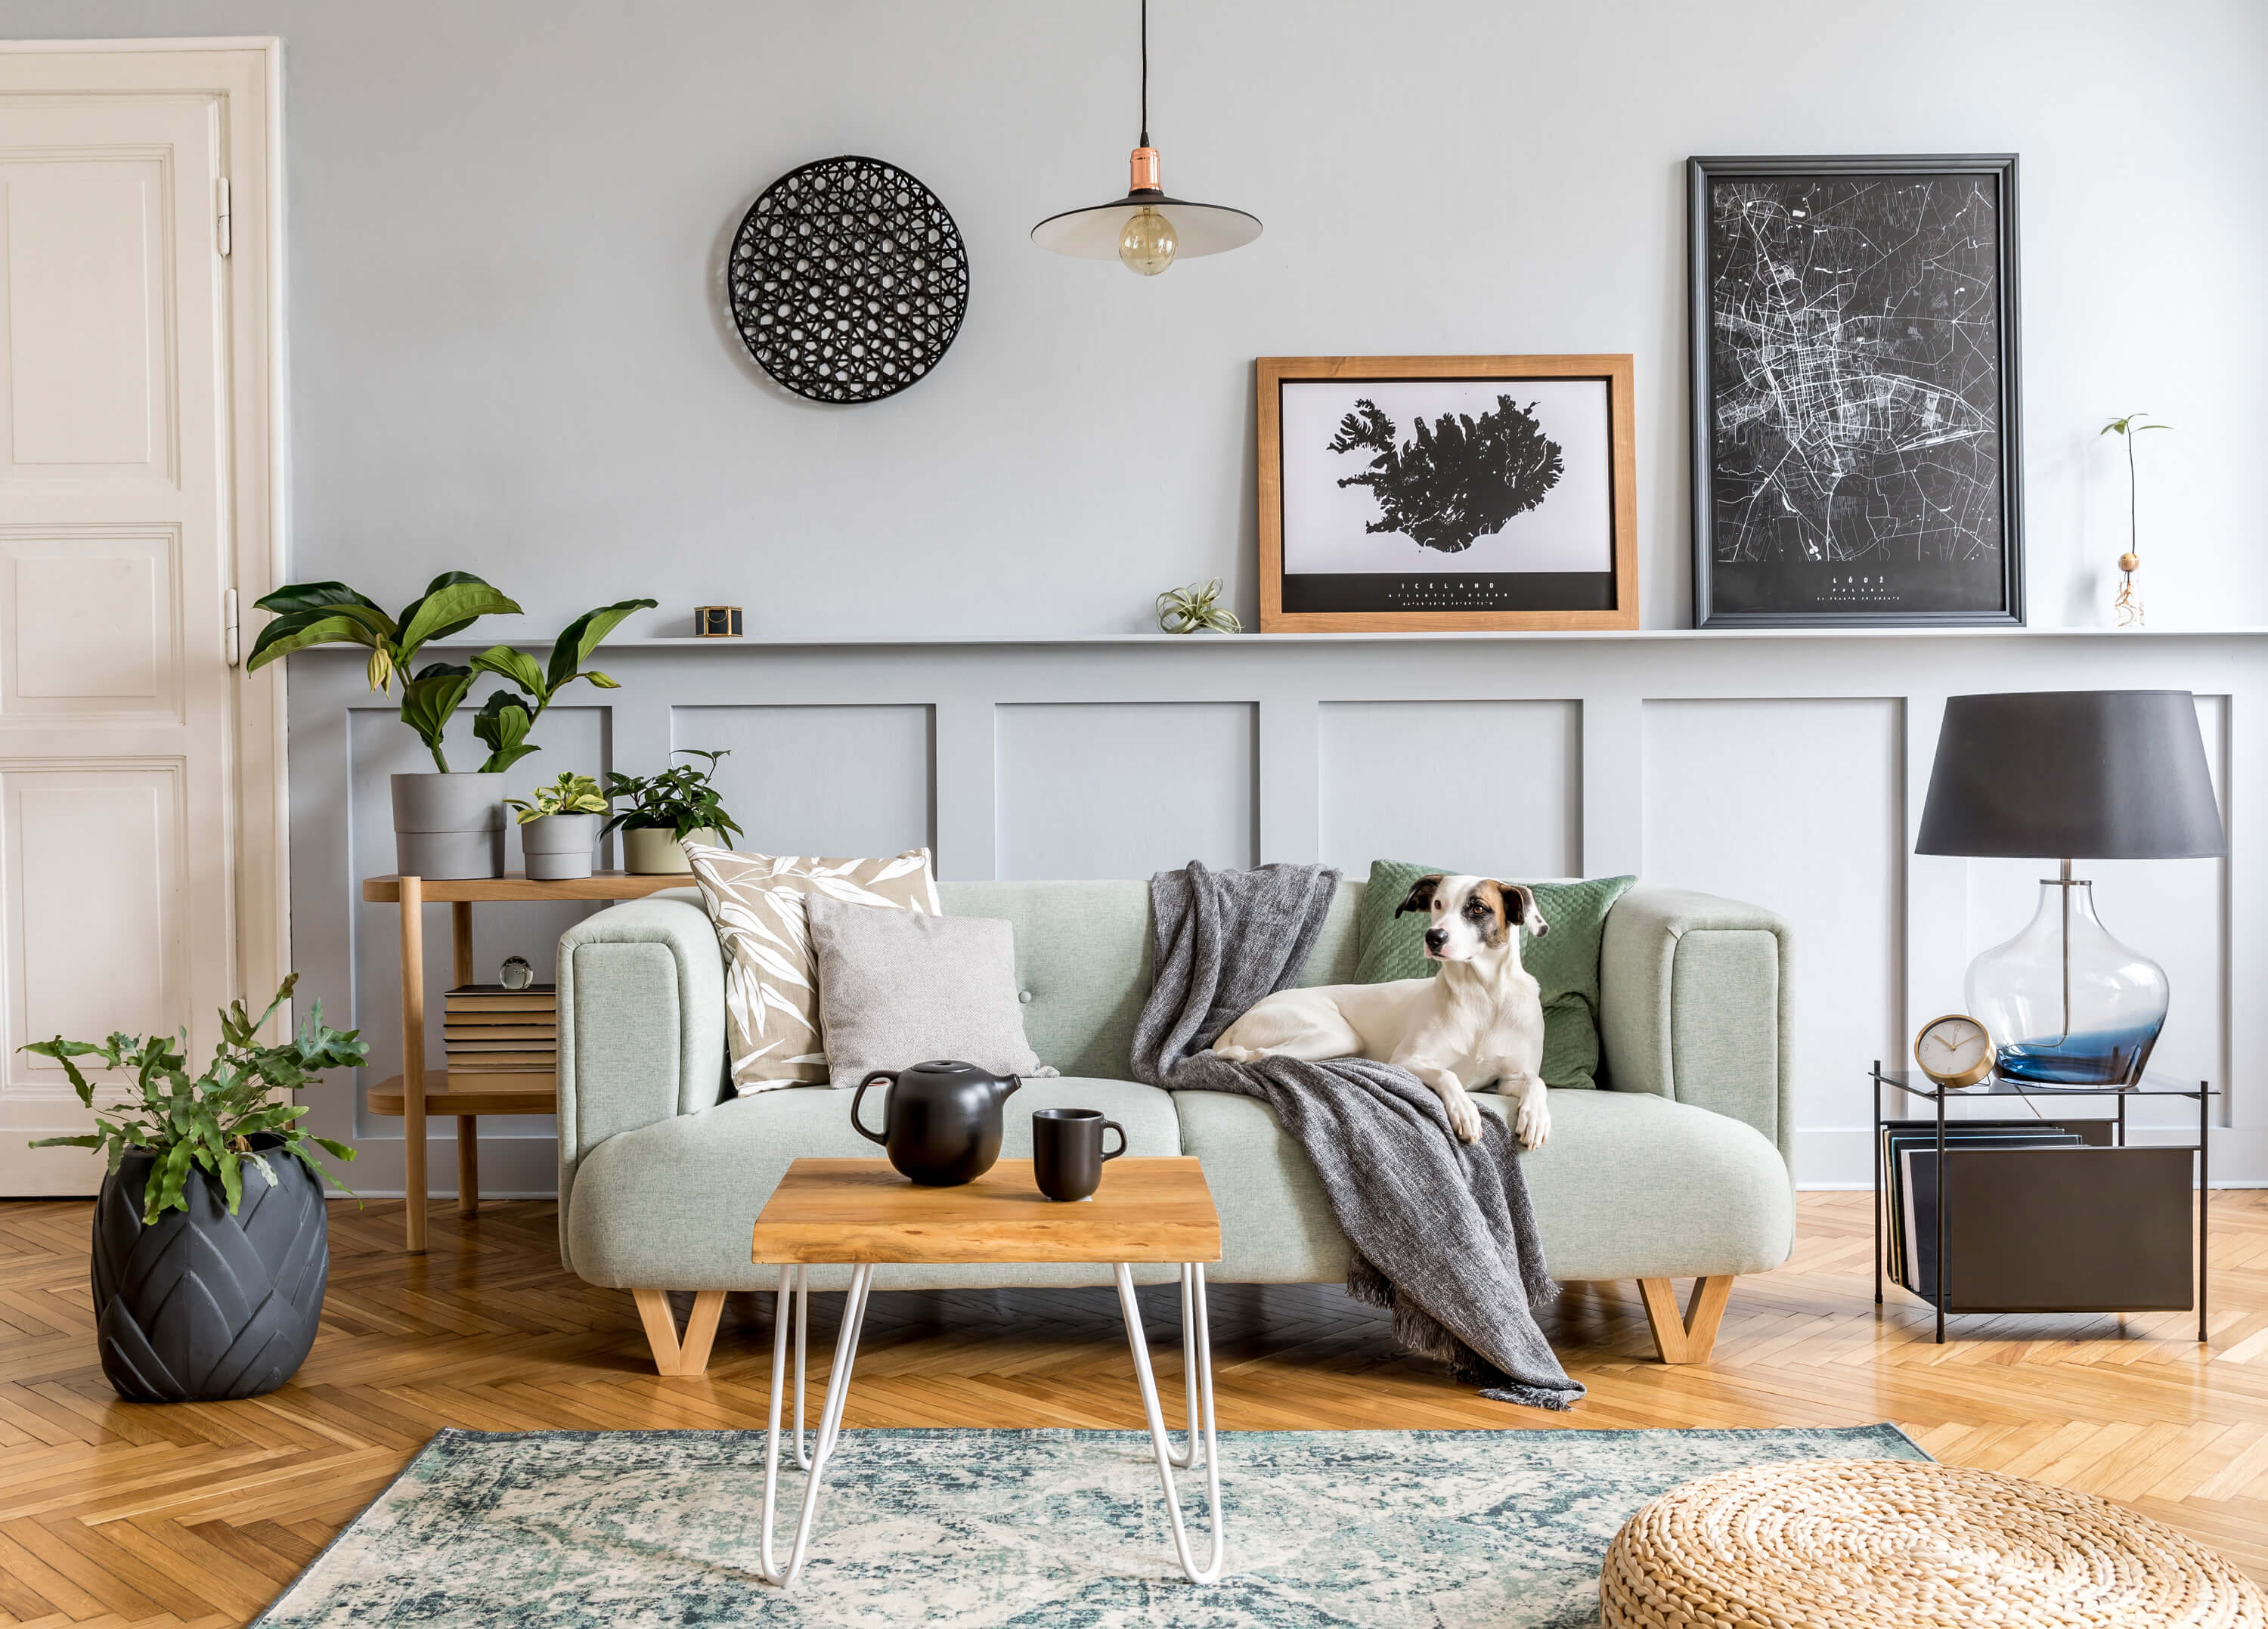

In [46]:
image_pil

In [12]:
ram_model = ram(pretrained="checkpoints/ram_swin_large_14m.pth", image_size=384, vit="swin_l", bert_cache=BERT_PATH)

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embeding dimension will be 30524. This might induce some performance reduction as *Tensor Cores* will not be available. For more details  about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


/encoder/layer/0/crossattention/self/query is tied
/encoder/layer/0/crossattention/self/key is tied
/encoder/layer/0/crossattention/self/value is tied
/encoder/layer/0/crossattention/output/dense is tied
/encoder/layer/0/crossattention/output/LayerNorm is tied
/encoder/layer/0/intermediate/dense is tied
/encoder/layer/0/output/dense is tied
/encoder/layer/0/output/LayerNorm is tied
/encoder/layer/1/crossattention/self/query is tied
/encoder/layer/1/crossattention/self/key is tied
/encoder/layer/1/crossattention/self/value is tied
/encoder/layer/1/crossattention/output/dense is tied
/encoder/layer/1/crossattention/output/LayerNorm is tied
/encoder/layer/1/intermediate/dense is tied
/encoder/layer/1/output/dense is tied
/encoder/layer/1/output/LayerNorm is tied
--------------
checkpoints/ram_swin_large_14m.pth
--------------
load checkpoint from checkpoints/ram_swin_large_14m.pth
vit: swin_l


In [13]:
device = torch.device('xpu')

In [14]:
image = image.to(device)

In [15]:
ram_model.eval()
ram_model.to(device)
ram_model = ipex.optimize(ram_model)

In [16]:
res = inference_ram.inference(image, ram_model)

In [17]:
res

('armchair | blanket | lamp | carpet | couch | dog | floor | furniture | gray | green | living room | picture frame | pillow | plant | room | sit | stool | wood floor',
 '扶手椅  | 毯子/覆盖层 | 灯  | 地毯  | 沙发 | 狗 | 地板/地面 | 家具  | 灰色 | 绿色  | 客厅  | 相框  | 枕头  | 植物  | 房间  | 坐/放置/坐落 | 凳子  | 木地板 ')

In [54]:
%timeit inference_ram.inference(image, ram_model)

48.1 ms ± 107 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [55]:
%timeit inference_ram.inference(image, ram_model)

48.3 ms ± 225 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [41]:
ram_bf16 = ram_model.bfloat16()
ram_bf16.eval()
ram_bf16.to(device)
ram_bf16 = ipex.optimize(ram_bf16)

In [43]:
res = inference_ram.inference(image.bfloat16(), ram_bf16)

In [44]:
res

('armchair | blanket | carpet | couch | dog | floor | furniture | gray | green | living room | picture frame | pillow | plant | room | sit | stool | wood floor',
 '扶手椅  | 毯子/覆盖层 | 地毯  | 沙发 | 狗 | 地板/地面 | 家具  | 灰色 | 绿色  | 客厅  | 相框  | 枕头  | 植物  | 房间  | 坐/放置/坐落 | 凳子  | 木地板 ')

In [18]:
classes=res[0].split(" | ")

In [19]:
captions = list(map(lambda s: s+'.', classes))

In [20]:
GDINO_CONFIG_PATH = "config/GroundingDINO_SwinT_OGC.py"
GDINO_CHECKPOINT_PATH = "checkpoints/groundingdino_swint_ogc.pth"

In [21]:
gdino = load_model(GDINO_CONFIG_PATH, GDINO_CHECKPOINT_PATH, BERT_PATH)
_ = gdino.to(device)
gdino = ipex.optimize(gdino)

final text_encoder_type: checkpoints/bert-base-uncased


In [22]:
SAM_ENCODER_VERSION = "vit_h"
SAM_CHECKPOINT_PATH = "./checkpoints/sam_vit_h_4b8939.pth"

In [23]:
sam = sam_model_registry[SAM_ENCODER_VERSION](checkpoint=SAM_CHECKPOINT_PATH)
sam = sam.to(device)
sam = ipex.optimize(sam)

In [24]:
sam_predictor = SamPredictor(sam)

In [25]:
boxes, logits, phrases = get_grounding_output(gdino, image, classes)

In [26]:
phrases

['picture frame',
 'picture frame',
 'lamp',
 'lamp',
 'carpet',
 'couch',
 'plant',
 'stool',
 'living room',
 'pillow',
 'plant',
 'dog',
 'pillow',
 'blanket',
 'armchair furniture',
 'plant',
 'pillow',
 'plant',
 'furniture stool',
 'picture frame',
 'plant',
 'room',
 'blanket pillow',
 'floor wood floor',
 'furniture']

In [30]:
class_ids = phrases2classes(phrases, classes)

In [31]:
class_ids

array([11, 11,  2,  2,  3,  4, 13, 16, 10, 12, 13,  5, 12,  1,  0, 13, 12,
       13,  7, 11, 13, 10,  1,  6,  7])

In [33]:
w, h = image_pil.size
detections = post_process_result(h, w, boxes, logits, phrases)

In [37]:
detections.mask = segment(
    sam_predictor=sam_predictor,
    image=np.array(image_pil),
    xyxy=detections.xyxy
)

In [40]:
# annotate image with detections
box_annotator = sv.BoxAnnotator()
mask_annotator = sv.MaskAnnotator()
labels = [
    f"{classes[class_id]} {confidence:0.2f}" 
    for _, _, confidence, class_id, _ 
    in detections]
annotated_image = mask_annotator.annotate(scene=np.array(image_pil), detections=detections)
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections, labels=labels)

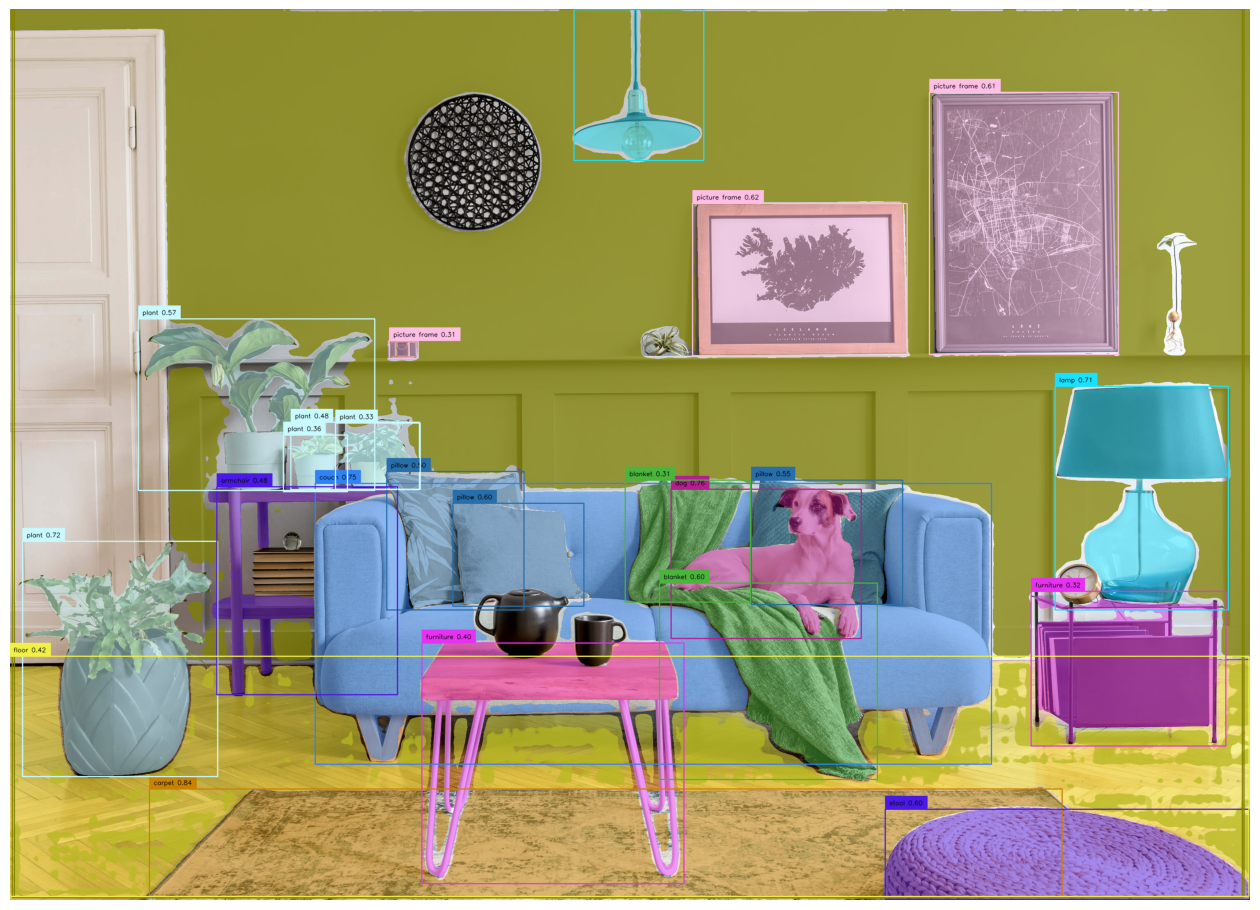

In [47]:
plt.figure(figsize=(16,12))
plt.imshow(annotated_image)
plt.axis('off')
plt.show()